# C3.ai COVID-19 Data Lake

This Jupyter notebook uses [C3.ai COVID-19 Data Lake](https://c3.ai/covid/) APIs to perform an exploratory analysis of the Coronavirus epidemic using recent clinical and demographic data from various academic and global health institutions

In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np

<a id="helpers"></a>
## Helper methods for accessing the API

The helper methods below (provided by C3.ai) convert a JSON response from the C3.ai APIs to a Pandas DataFrame, this cell should be run before querying the API

In [2]:
def read_data_json(typename, api, body):
    """
    read_data_json directly accesses the C3.ai COVID-19 Data Lake APIs using the requests library, 
    and returns the response as a JSON, raising an error if the call fails for any reason.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    api: The API you want to access, either 'fetch' or 'evalmetrics'.
    body: The spec you want to pass. For examples, see the API documentation.
    """
    response = requests.post(
        "https://api.c3.ai/covid/api/1/" + typename + "/" + api, 
        json = body, 
        headers = {
            'Accept' : 'application/json', 
            'Content-Type' : 'application/json'
        }
    )
    response.raise_for_status()
    
    return response.json()

def fetch(typename, body, get_all = False, remove_meta = True):
    """
    fetch accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe. 
    fetch is used for all non-timeseries data in the C3.ai COVID-19 Data Lake, and will call read_data as many times 
    as required to access all of the relevant data for a given typename and body.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    get_all: If True, get all records and ignore any limit argument passed in the body. If False, use the limit argument passed in the body. The default is False.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    if get_all:
        has_more = True
        offset = 0
        limit = 2000
        df = pd.DataFrame()

        while has_more:
            body['spec'].update(limit = limit, offset = offset)
            response_json = read_data_json(typename, 'fetch', body)
            new_df = pd.json_normalize(response_json['objs'])
            df = df.append(new_df)
            has_more = response_json['hasMore']
            offset += limit
            
    else:
        response_json = read_data_json(typename, 'fetch', body)
        df = pd.json_normalize(response_json['objs'])
        
    if remove_meta:
        df = df.drop(columns = [c for c in df.columns if ('meta' in c) | ('version' in c)])
    
    return df
    
def evalmetrics(typename, body, get_all = False, remove_meta = True):
    """
    evalmetrics accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe.
    evalmetrics is used for all timeseries data in the C3.ai COVID-19 Data Lake.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    get_all: If True, get all metrics and ignore limits on number of expressions and ids. If False, consider expressions and ids limits. The default is False.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    if get_all:
        expressions = body['spec']['expressions']
        ids = body['spec']['ids']
        df = pd.DataFrame()
        
        for ids_start in range(0, len(ids), 10):
            for expressions_start in range(0, len(expressions), 4):
                body['spec'].update(
                    ids = ids[ids_start : ids_start + 10],
                    expressions = expressions[expressions_start : expressions_start + 4]
                )
                response_json = read_data_json(typename, 'evalmetrics', body)
                new_df = pd.json_normalize(response_json['result'])
                new_df = new_df.apply(pd.Series.explode)
                df = pd.concat([df, new_df], axis = 1)
            
    else:
        response_json = read_data_json(typename, 'evalmetrics', body)
        df = pd.json_normalize(response_json['result'])
        df = df.apply(pd.Series.explode)

    # get the useful data out
    if remove_meta:
        df = df.filter(regex = 'dates|data|missing')
    
    # only keep one date column
    date_cols = [col for col in df.columns if 'dates' in col]
    keep_cols =  date_cols[:1] + [col for col in df.columns if 'dates' not in col]
    df = df.filter(items = keep_cols).rename(columns = {date_cols[0] : "dates"})
    df["dates"] = pd.to_datetime(df["dates"])
    
    return df

def getprojectionhistory(body, remove_meta = True):
    """
    getprojectionhistory accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe.
    ------
    body: The spec you want to pass. For examples, see the API documentation.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """  
    response_json = read_data_json("outbreaklocation", 'getprojectionhistory', body)
    df = pd.json_normalize(response_json)
    df = df.apply(pd.Series.explode)

    # get the useful data out
    if remove_meta:
        df = df.filter(regex = 'dates|data|missing|expr')
    
    # only keep one date column
    date_cols = [col for col in df.columns if 'dates' in col]
    keep_cols =  date_cols[:1] + [col for col in df.columns if 'dates' not in col]
    df = df.filter(items = keep_cols).rename(columns = {date_cols[0] : "dates"})
    df["dates"] = pd.to_datetime(df["dates"])
    
    # rename columns to simplify naming convention
    df = df.rename(columns = lambda x: x.replace(".value", ""))
    
    return df

<a id="outbreaklocation"></a>
## Get Outbreak Location data

OutbreakLocation stores location data such as countries, provinces, cities, where COVID-19 outbeaks have occured and are recorded. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/OutbreakLocation) for details and for a list of available locations.

In [3]:
# i.e. Fetch facts about Brazil
locations = fetch(
    "outbreaklocation",
    {
        "spec" : {
            "filter" : "id == 'Brazil'"
        }
    }
)

locations

,latestTotalPopulation,populationOfAllChildren,locationType,populationCDS,countryArea,countryCode,population2018,id,name,typeIdent,hospitalPrediction.timestamp,location.value.id,location.timestamp,fips.id
0,232304177.0,232304177.0,country,208494900,8358140.0,BR,209469333,Brazil,Brazil,EP_LOC,2019-01-01T00:00:00,Brazil,2020-05-18T00:00:00Z,BR


<a id="outbreaklocation/casecounts"></a>
### Case counts

Counts of cases, deaths, recoveries, and other statistics for counties, provinces, and countries worldwide via John Hopkins, The EDCD, or Covid Tracking Project.

In [4]:
# Total number of confirmed cases, deaths, and recoveries in Hennepin County, Minnesota
today = pd.Timestamp.now().strftime("%Y-%m-%d")

casecounts = evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["Hennepin_Minnesota_UnitedStates"],
            "expressions" : ["JHU_ConfirmedCases", "JHU_ConfirmedDeaths", "JHU_ConfirmedRecoveries"],
            "start" : "2020-01-01",
            "end" : today,
            "interval" : "DAY",
        }
    }
)

casecounts

,dates,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.missing,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.missing,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.missing
0,2020-01-01,0,0,0,0,0,100
0,2020-01-02,0,0,0,0,0,100
0,2020-01-03,0,0,0,0,0,100
0,2020-01-04,0,0,0,0,0,100
0,2020-01-05,0,0,0,0,0,100
...,...,...,...,...,...,...,...
0,2020-06-14,10191,0,716,0,0,0
0,2020-06-15,10281,0,720,0,0,0
0,2020-06-16,10323,0,724,0,0,0
0,2020-06-17,10415,0,727,0,0,0


Plot these counts.

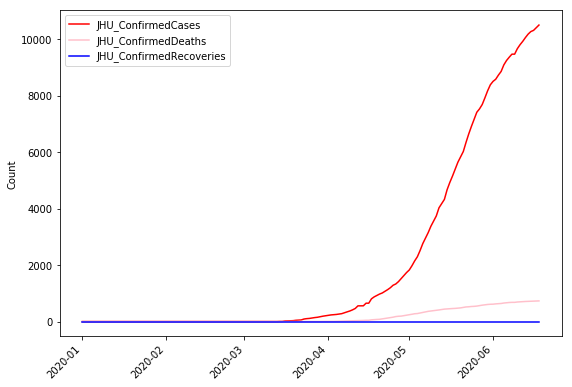

In [5]:
plt.figure(figsize = (9, 6))
plt.plot(
    casecounts["dates"],
    casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data"],
    label = "JHU_ConfirmedCases", color='red'
)
plt.plot(
    casecounts["dates"],
    casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data"],
    label = "JHU_ConfirmedDeaths", color='pink'
)
plt.plot(
    casecounts["dates"],
    casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data"],
    label = "JHU_ConfirmedRecoveries", color='blue'
)
plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Count")
plt.show()

Export case counts as a .csv file.

In [6]:
# Uncomment the line below to export the DataFrame as a .csv file
# casecounts.to_csv("casecounts.csv")

<a id="outbreaklocation/demographics"></a>
### Demographics

Demographic and economic data from the US Census Bureau and The World Bank allow demographic comparisons across locations. 

In [7]:
population = fetch(
    "populationdata",
    {
        "spec" : {
            "filter" : "!contains(parent, '_') && (populationAge == '>=65' || populationAge == 'Total') && gender == 'Male/Female' && year == '2018' && estimate == 'False' && percent == 'False'"
        }
    },
    get_all = True
)

population

,year,gender,populationAge,estimate,median,percent,value,minAge,origin,id,timestamp,parent.id
0,2018,Male/Female,>=65,False,False,False,960879.0,65.0,World Bank,2018_Afghanistan_Male/Female_>=65_Count_SP.POP...,2018-01-01T00:00:00Z,Afghanistan
1,2018,Male/Female,Total,False,False,False,37172386.0,NaN,World Bank,2018_Afghanistan_Male/Female_Total_Count_SP.PO...,2018-01-01T00:00:00Z,Afghanistan
2,2018,Male/Female,>=65,False,False,False,393976.0,65.0,World Bank,2018_Albania_Male/Female_>=65_Count_SP.POP.65U...,2018-01-01T00:00:00Z,Albania
3,2018,Male/Female,Total,False,False,False,2866376.0,NaN,World Bank,2018_Albania_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Albania
4,2018,Male/Female,>=65,False,False,False,2686782.0,65.0,World Bank,2018_Algeria_Male/Female_>=65_Count_SP.POP.65U...,2018-01-01T00:00:00Z,Algeria
...,...,...,...,...,...,...,...,...,...,...,...,...
479,2018,Male/Female,Total,False,False,False,28498687.0,NaN,World Bank,2018_Yemen_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Yemen
480,2018,Male/Female,>=65,False,False,False,364332.0,65.0,World Bank,2018_Zambia_Male/Female_>=65_Count_SP.POP.65UP.TO,2018-01-01T00:00:00Z,Zambia
481,2018,Male/Female,Total,False,False,False,17351822.0,NaN,World Bank,2018_Zambia_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Zambia
482,2018,Male/Female,>=65,False,False,False,424438.0,65.0,World Bank,2018_Zimbabwe_Male/Female_>=65_Count_SP.POP.65...,2018-01-01T00:00:00Z,Zimbabwe


In [8]:
population_age_distribution = population.loc[
    :, 
    ["populationAge", "parent.id", "value"]
].pivot(index = "parent.id", columns = "populationAge")['value']
population_age_distribution["proportion_over_65"] = population_age_distribution[">=65"] / population_age_distribution["Total"]

population_age_distribution

populationAge,>=65,Total,proportion_over_65
parent.id,,,
Afghanistan,960879.0,3.717239e+07,0.025849
Albania,393976.0,2.866376e+06,0.137447
Algeria,2686782.0,4.222843e+07,0.063625
Andorra,NaN,7.700600e+04,NaN
Angola,682859.0,3.080976e+07,0.022164
...,...,...,...
WestBankandGaza,143163.0,4.569087e+06,0.031333
World,673618927.0,7.594270e+09,0.088701
Yemen,819699.0,2.849869e+07,0.028763


Get world wide death counts.

In [9]:
global_deaths = evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : list(population_age_distribution.index),
            "expressions" : ["JHU_ConfirmedDeaths"],
            "start" : "2020-06-01",
            "end" : "2020-06-01",
            "interval" : "DAY",
        }
    },
    get_all = True
)

global_deaths

,dates,Armenia.JHU_ConfirmedDeaths.data,Armenia.JHU_ConfirmedDeaths.missing,Afghanistan.JHU_ConfirmedDeaths.data,Afghanistan.JHU_ConfirmedDeaths.missing,Argentina.JHU_ConfirmedDeaths.data,Argentina.JHU_ConfirmedDeaths.missing,Angola.JHU_ConfirmedDeaths.data,Angola.JHU_ConfirmedDeaths.missing,AntiguaandBarbuda.JHU_ConfirmedDeaths.data,...,WestBankandGaza.JHU_ConfirmedDeaths.data,WestBankandGaza.JHU_ConfirmedDeaths.missing,UnitedStates.JHU_ConfirmedDeaths.data,UnitedStates.JHU_ConfirmedDeaths.missing,Yemen.JHU_ConfirmedDeaths.data,Yemen.JHU_ConfirmedDeaths.missing,Zimbabwe.JHU_ConfirmedDeaths.data,Zimbabwe.JHU_ConfirmedDeaths.missing,Zambia.JHU_ConfirmedDeaths.data,Zambia.JHU_ConfirmedDeaths.missing
0,2020-06-01,139,0,265,0,556,0,4,0,3,...,3,0,105165,0,84,0,4,0,7,0


In [10]:
global_deaths_by_country = global_deaths.filter(regex=("\.data")).melt()
global_deaths_by_country["country"] = global_deaths_by_country["variable"].str.replace("\..*", "")

global_comparison = global_deaths_by_country.set_index("country").join(population_age_distribution)
global_comparison["deaths_per_million"] = 1e6 * global_comparison["value"] / global_comparison["Total"] 
global_comparison

,variable,value,>=65,Total,proportion_over_65,deaths_per_million
country,,,,,,
Armenia,Armenia.JHU_ConfirmedDeaths.data,139,332187.0,2951776.0,0.112538,47.0903
Afghanistan,Afghanistan.JHU_ConfirmedDeaths.data,265,960879.0,37172386.0,0.025849,7.12895
Argentina,Argentina.JHU_ConfirmedDeaths.data,556,4946805.0,44494502.0,0.111178,12.4959
Angola,Angola.JHU_ConfirmedDeaths.data,4,682859.0,30809762.0,0.022164,0.129829
AntiguaandBarbuda,AntiguaandBarbuda.JHU_ConfirmedDeaths.data,3,8473.0,96286.0,0.087998,31.1572
...,...,...,...,...,...,...
WestBankandGaza,WestBankandGaza.JHU_ConfirmedDeaths.data,3,143163.0,4569087.0,0.031333,0.656586
UnitedStates,UnitedStates.JHU_ConfirmedDeaths.data,105165,51641630.0,326687501.0,0.158077,321.913
Yemen,Yemen.JHU_ConfirmedDeaths.data,84,819699.0,28498687.0,0.028763,2.9475


Visualize the results.

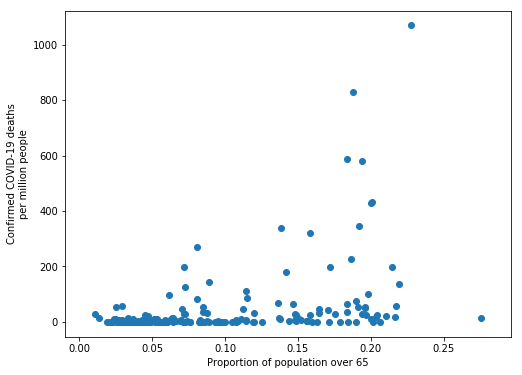

In [11]:
plt.figure(figsize = (8, 6))
plt.scatter(
    global_comparison["proportion_over_65"],
    global_comparison["deaths_per_million"]
)
plt.xlabel("Proportion of population over 65")
plt.ylabel("Confirmed COVID-19 deaths\nper million people")
plt.show()

<a id="linelistrecord"></a>
## Get LineListRecord data

LineListRecord stores row-level crowdsourced data from laboratory-confirmed COVID-19 patients. This data includes gender, age, symptoms, travel history, location, reported onset, confirmation dates, and discharge status. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LineListRecord) for details.

In [28]:
# Fetch the line list records tracked by MOBS Lab
records = fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'DXY'"
        }
    },
    get_all = True
)

#print(records.columns.values)
records

,age,gender,symptomStartDate,exposureStartDate,exposureEndDate,hospitalAdmissionDate,caseConfirmationDate,livesInGroundZero,traveledToGroundZero,traveler,internationTraveler,domesticTraveler,notes,outcome,didDie,didRecover,recordSource,lineListSource,hasTravelHistory,id,location.id,caseInCountry,symptoms
0,66.0,male,2020-01-03T00:00:00Z,2019-12-29T00:00:00Z,2020-01-04T00:00:00Z,2020-01-11T00:00:00Z,2020-01-20T00:00:00Z,False,False,False,False,False,First confirmed imported COVID-19 pneumonia pa...,open,False,False,Shenzhen Municipal Health Commission: http://w...,DXY,False,1,ShenzhenGuangdong_China,NaN,NaN
1,56.0,male,2020-01-16T00:00:00Z,2020-01-08T00:00:00Z,2020-01-16T00:00:00Z,2020-01-20T00:00:00Z,2020-01-21T00:00:00Z,False,False,False,False,False,new confirmed imported COVID-19 pneumonia pati...,open,False,False,Beijing Municipal Health Commission: http://wj...,DXY,False,10,Beijing_China,NaN,NaN
2,70.0,male,2020-01-15T00:00:00Z,NaN,NaN,2020-01-19T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,False,False,"Death from COVID-19 pneumonia in Wuhan: male, ...",open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,100,WuhanHubei_China,NaN,NaN
3,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1000,UnitedStates,56.0,NaN
4,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1001,UnitedStates,57.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,995,UnitedStates,51.0,NaN
1393,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,996,UnitedStates,52.0,NaN
1394,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,997,UnitedStates,53.0,NaN
1395,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,False,False,new confirmed COVID-19 patient in US: passenge...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,998,UnitedStates,54.0,NaN


What are the most common symptoms in the dataset?

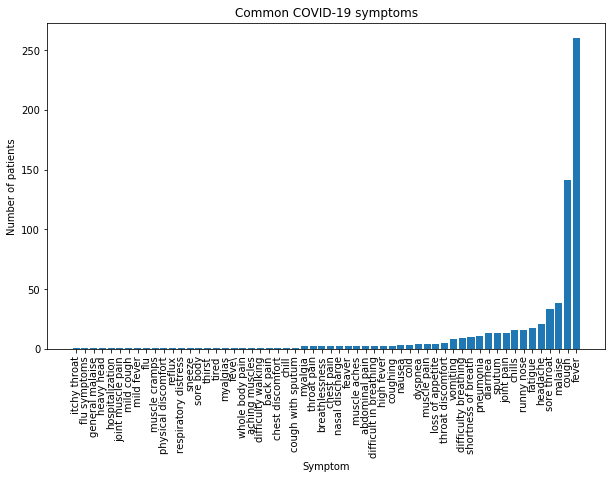

In [13]:
# Get all the symptoms, which are initially comma-separated
symptom_df = records.copy()
symptom_df["symptoms"] = symptom_df["symptoms"].str.split(", ")
symptom_df = symptom_df.explode("symptoms")
symptom_df = symptom_df.dropna(subset = ["symptoms"])
symptom_freq = symptom_df.groupby(["symptoms"]).agg("count")[["id"]].sort_values("id")

# Plot the data
plt.figure(figsize = (10, 6))
plt.bar(symptom_freq.index, symptom_freq["id"])
plt.xticks(rotation = 90)
plt.xlabel("Symptom")
plt.ylabel("Number of patients")
plt.title("Common COVID-19 symptoms")
plt.show()

In [14]:
symptom_freq.head()

,id
symptoms,
itchy throat,1
flu symptoms,1
general malaise,1
heavy head,1
hospitalization,1


How long does it take for a symptomatic person to become hospitalized after developing symptoms?

In [15]:
# Drop null values/records from the desired columns
hospitalized = records.dropna(subset = ["hospitalAdmissionDate", "symptomStartDate"])

# Get the number of days from development of symptoms to hospitalization for each patient
hospitalization_time = np.array(
    pd.to_datetime(hospitalized['hospitalAdmissionDate']) - pd.to_datetime(hospitalized['symptomStartDate'])
).astype('timedelta64[D]').astype('float')
hospitalization_time = hospitalization_time[hospitalization_time >= 0]

# Hospitalization time of 0 days is replaced with 0.1 to indicate immediate hospitalization
hospitalization_time[hospitalization_time <= 0.1] = 0.1

hospitalization_time

array([ 8. ,  4. ,  4. ,  7. ,  6. , 10. ,  7. , 10. , 15. ,  1. , 10. ,
        1. ,  5. ,  4. ,  9. ,  2. ,  7. ,  7. ,  1. ,  1. ,  1. ,  5. ,
        2. ,  7. , 12. ,  4. ,  0.1,  1. ,  0.1,  0.1,  5. ,  5. ,  2. ,
        9. ,  0.1,  8. ,  3. ,  0.1,  2. ,  2. ,  6. ,  4. ,  6. ,  2. ,
        0.1,  2. ,  0.1,  5. ,  2. ,  0.1,  1. ,  0.1,  0.1,  0.1, 10. ,
        6. ,  5. ,  0.1,  1. ,  3. ,  3. ,  3. , 12. ,  1. ,  4. ,  2. ,
        0.1,  0.1,  8. ,  4. ,  3. ,  4. ,  4. , 14. ,  2. ,  1. ,  6. ,
        2. ,  0.1,  0.1,  2. ,  3. ,  0.1,  6. ,  0.1,  5. ,  2. ,  0.1,
        5. ,  4. ,  0.1,  1. ,  3. ,  1. ,  2. ,  1. ,  4. ,  3. ,  1. ,
        0.1,  2. ,  0.1,  0.1,  5. ,  9. ,  4. ,  1. ,  0.1,  1. ,  3. ,
        0.1,  3. ,  0.1,  1. ,  0.1,  0.1,  3. ,  0.1,  2. ,  0.1,  0.1,
        0.1,  0.1,  6. ,  8. ,  6. ,  0.1,  8. ,  1. ,  8. ,  5. ,  7. ,
        3. ,  1. ,  5. ,  2. ,  1. ,  1. ,  1. ,  3. ,  0.1,  0.1,  1. ,
        4. ,  0.1,  0.1,  0.1,  1. ,  2. ,  2. ,  0

16


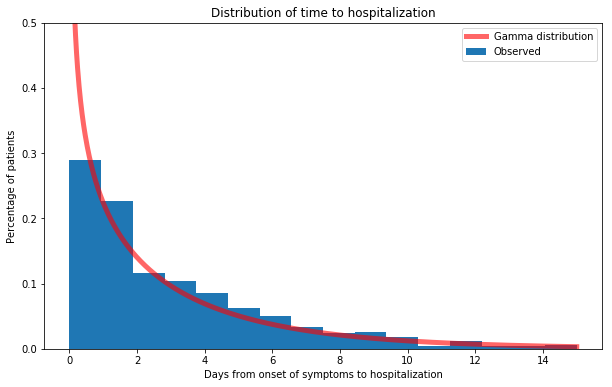

In [16]:
# Fit a gamma distribution
a, loc, scale = gamma.fit(hospitalization_time, floc = 0)
dist = gamma(a, loc, scale)

# Plot the results
x = np.linspace(0, np.max(hospitalization_time), 1000)
n_bins = int(np.max(hospitalization_time) + 1)
print(n_bins)

plt.figure(figsize = (10, 6))
plt.hist(
    hospitalization_time, 
    bins = n_bins, 
    range = (0, np.max(hospitalization_time)), 
    density = True, 
    label = "Observed"
)
plt.plot(x, dist.pdf(x), 'r-', lw=5, alpha=0.6, label = 'Gamma distribution')
plt.ylim(0, 0.5)
plt.xlabel("Days from onset of symptoms to hospitalization")
plt.ylabel("Percentage of patients")
plt.title("Distribution of time to hospitalization")
plt.legend()
plt.show()

In [25]:
# Fetch the line list records tracked by nCoV2019 Data Working Group
records2 = fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'OPEN'"
        }
    },
    get_all = True
)

#print(records.columns.values)
pd.set_option('display.max_columns', None)
records2

,age,gender,caseConfirmationDate,livesInGroundZero,traveledToGroundZero,recordSource,lineListSource,hasTravelHistory,id,location.id,locationType,groundZeroExposure,notes,relevantTravelHistoryLocation,sequenceAvailable,symptomStartDate,hospitalAdmissionDate,relevantTravelHistoryDates,outcome,didDie,didRecover,outcomeDate,symptoms,ageRange,chronicDisease
0,27.0,female,2020-04-04T00:00:00Z,False,False,https://www.prensalibre.com/guatemala/comunita...,OPEN,False,00002e80-d790-4d77-aa02-7da86338c41b,GuatemalaCity_GuatemalaCity_Guatemala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2020-03-26T00:00:00Z,False,False,NaN,OPEN,False,00004cec-61fe-43a0-b4c4-cbb2a2c4e932,NewcastleuponTyneTyneandWear_England_UnitedKin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2020-03-25T00:00:00Z,False,False,https://coronavirus.health.ny.gov/county-count...,OPEN,False,00009339-ab52-4de7-afad-3a8ca35f700e,NewYork_UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2020-03-22T00:00:00Z,False,False,https://coronavirus.health.ny.gov/county-count...,OPEN,False,0000ef82-6365-4ee6-bb44-00b8575dbf3c,NewYorkCity_NewYork_UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2020-03-29T00:00:00Z,False,False,https://www.mercurynews.com/2020/03/20/map-cor...,OPEN,False,000174f4-8b80-4832-b7d5-333e4a3ccfcf,California_UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,NaN,NaN,2020-03-23T00:00:00Z,False,False,https://www.rki.de/DE/Content/InfAZ/N/Neuartig...,OPEN,False,ffff04d1-239a-4e3c-a983-7c927382b157,Bavaria_Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
867,NaN,NaN,2020-02-06T00:00:00Z,False,False,http://wjw.hunan.gov.cn/wjw/xxgk/gzdt/zyxw_1/2...,OPEN,False,ffff0ebf-9d94-43b7-ada2-688bb84057fd,YongzhouCity_Hunan_China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
868,NaN,NaN,2020-03-25T00:00:00Z,False,False,https://www.nj.gov/health/cd/topics/covid2019_...,OPEN,False,ffff15af-e211-441b-aded-1442599c936a,NewJersey_UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,NaN,NaN,2020-02-01T00:00:00Z,False,False,https://bnonews.com/index.php/2020/01/the-late...,OPEN,False,ffff1bb3-7bf8-4dcc-bda5-fa632a8f7d91,Beijing_China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#records2['chronicDisease'].unique()
records2.to_csv("Covid19_LineList_Records.csv")